# Vehicle Data Analysis 
## by Haoda Song

All codes for three questions are finished within two hours. Extensions, e.g. EDA and additional interesting findings, are at the end of the notebook. (A part of the extension exceeds two hours but three questions are definitely completed within the time limitation.)

In [254]:
import numpy as np
import pandas as pd
vehicle = pd.DataFrame(pd.read_csv("vehicles.csv"))

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (73,74,76) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Data structure:
We have 40081 observations and 83 features (23 categorical features, 59 numerical features and 1 boolean(binary) feature) in the given dataset. Many features contain too many missing values.

In [65]:
#Data Structure and Missing values' pattern
print('data dimensions:',vehicle.shape)
perc_missing_per_ftr = vehicle.isnull().sum(axis=0)/vehicle.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(vehicle[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(vehicle.isnull().sum(axis=1)!=0)/vehicle.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (40081, 83)
fraction of missing values in features:
cylinders     0.004266
displ         0.004216
drive         0.029665
eng_dscr      0.396672
trany         0.000274
guzzler       0.940695
trans_dscr    0.624585
tCharger      0.842768
sCharger      0.980140
atvType       0.915820
fuelType2     0.961403
rangeA        0.961528
evMotor       0.981637
mfrCode       0.768893
c240Dscr      0.998378
c240bDscr     0.998428
startStop     0.790998
dtype: float64
data types of the features with missing values:
cylinders     float64
displ         float64
drive          object
eng_dscr       object
trany          object
guzzler        object
trans_dscr     object
tCharger       object
sCharger       object
atvType        object
fuelType2      object
rangeA         object
evMotor        object
mfrCode        object
c240Dscr       object
c240bDscr      object
startStop      object
dtype: object
fraction of points with missing values: 1.0


### Handle missing values:
Some features contain missing values above 90% but we cannot drop these columns since we don't know the importance of these columns. Typically, we would ask the clients or others who know the background of the data if they believe some columns are important intuitively. If they believe the features are not important, we could drop the features.


However, we may still have around 400 data points in our data if 99% are missing. One option is to treat these missing values as one category since most of these features are categorical/discrete features. Also, for continuous features, cylinders and displ, we would impute the missing values since they are only 0.4266% are missing.



Also, another choice is to use XGBoost model which would handle the missing values automatically. But I may not have enough time to fit the XGBoost model for this large dataset because of the XGBoost algorithm.

### Q1: Which manufacturer produces the most fuel efficient fleet of cars?

In [4]:
vehicle['make'].value_counts() # There are total 135 manufacturers but some are only contains one car.

Chevrolet                             3944
Ford                                  3284
Dodge                                 2559
GMC                                   2471
Toyota                                2010
                                      ... 
S and S Coach Company  E.p. Dutton       1
Volga Associated Automobile              1
Panos                                    1
Superior Coaches Div E.p. Dutton         1
Aurora Cars Ltd                          1
Name: make, Length: 135, dtype: int64

MPG : mile per gallon. The higher MPG is, the more efficient the fuel is.

The Combined MPG value is the most prominent for the purpose of quick and easy comparison across vehicles. Combined fuel economy is a weighted average of City and Highway MPG values that is calculated by weighting the City value by 55% and the Highway value by 45%. 

Therefore, I would use this feature to evaluate the overall fuel economy. Although most of the cars belong to Fuel Type 1 (single fuel or dual fuel with conventional fuel), I still would like to see the performances of the cars in Fuel Type 2 (dual fuel with alternative fuel).

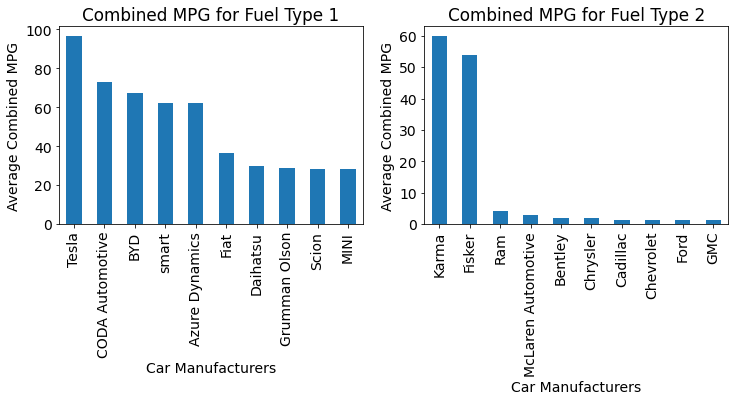

In [501]:
import matplotlib.pyplot as plt
#Fuel Type 1
#For single fuel vehicles, the vehicles which made by Tesla are the most economic.
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
comb_type1 = vehicle.groupby('make').mean().sort_values(by='comb08',ascending=False)['comb08'][:10]
comb_type1.plot.bar()
plt.title("Combined MPG for Fuel Type 1")
plt.ylabel("Average Combined MPG")
plt.xlabel("Car Manufacturers")


## For dual fuel vehicles, the vehicles which made by Karma are the most economic (60,54 >>> 4,2)
plt.subplot(2,2,2)
comb_type2 = vehicle.groupby('make').mean().sort_values(by='combA08',ascending=False)['combA08'][:10]
comb_type2.plot.bar()
plt.title("Combined MPG for Fuel Type 2")
plt.ylabel("Average Combined MPG")
plt.xlabel("Car Manufacturers")
plt.show()

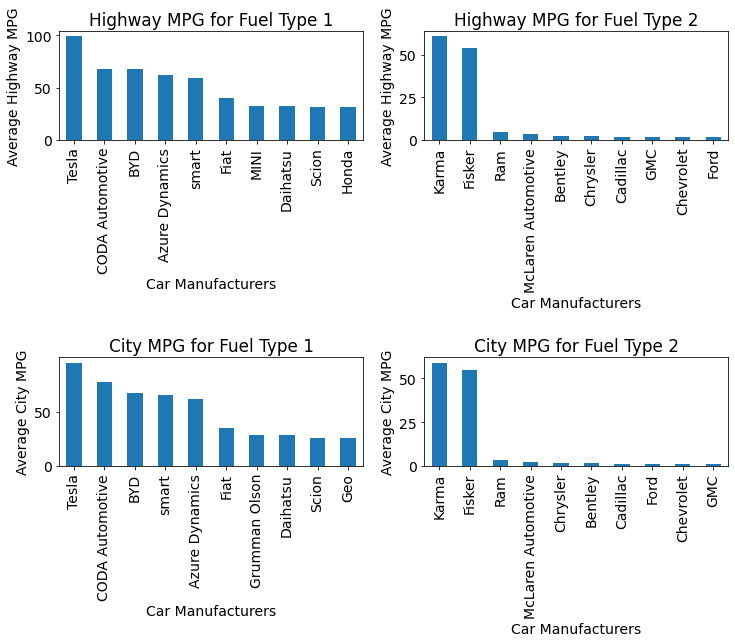

In [500]:
#After we checked the overall MPG (fuel economy), let's see the peformances of fuel economy on highway and city
# Highway MPGs
hw_type1 = vehicle.groupby('make').mean().sort_values(by='highway08',ascending=False)['highway08'][:10]
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
hw_type1.plot.bar()
plt.title("Highway MPG for Fuel Type 1")
plt.ylabel("Average Highway MPG")
plt.xlabel("Car Manufacturers")


hw_type2 = vehicle.groupby('make').mean().sort_values(by='highwayA08',ascending=False)['highwayA08'][:10]
plt.subplot(2,2,2)
hw_type2.plot.bar()
plt.title("Highway MPG for Fuel Type 2")
plt.ylabel("Average Highway MPG")
plt.xlabel("Car Manufacturers")

#City MPGs
ci_type1 = vehicle.groupby('make').mean().sort_values(by='city08',ascending=False)['city08'][:10]
plt.subplot(2,2,3)
ci_type1.plot.bar()
plt.title("City MPG for Fuel Type 1")
plt.ylabel("Average City MPG")
plt.xlabel("Car Manufacturers")


ci_type2 = vehicle.groupby('make').mean().sort_values(by='cityA08',ascending=False)['cityA08'][:10]
plt.subplot(2,2,4)
ci_type2.plot.bar()
plt.title("City MPG for Fuel Type 2")
plt.ylabel("Average City MPG")
plt.xlabel("Car Manufacturers")
plt.subplots_adjust(hspace=2)
plt.show()

#### Answer:
Whatever in highways, cities, or both, Tesla produces the most fuel-efficient fleet of cars. Additionally, based on the performances of dual-fuel cars with alternative fuel, Karma and Fisker produce the top two alternative fuel-efficient fleet of cars.

### Q2: Build a model to predict city mpg (variable “UCity” in column BG).

In [106]:
random_state=42 
y = vehicle['UCity'] # Our Target Variable
X = vehicle.loc[:, vehicle.columns != 'UCity'] # Our features

#### Different column names in different data types 
(Prepared for data preprocessing)

In [243]:
print("Categorical feature names:", list(vehicle.select_dtypes(include=["object"]).columns))
print("Number of cetegorical features:",len(vehicle.select_dtypes(include=["object"]).columns))
print("Numerical feature names:", list(vehicle.select_dtypes(include=["number"]).columns))
print("Number of numerical features:",len(vehicle.select_dtypes(include=["number"]).columns))
print("Boolean feature names:", list(vehicle.select_dtypes(include=["bool"]).columns))
print("Number of boolean features:",len(vehicle.select_dtypes(include=["bool"]).columns))

Categorical feature names: ['drive', 'eng_dscr', 'fuelType', 'fuelType1', 'make', 'model', 'mpgData', 'trany', 'VClass', 'guzzler', 'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'fuelType2', 'rangeA', 'evMotor', 'mfrCode', 'c240Dscr', 'c240bDscr', 'createdOn', 'modifiedOn', 'startStop']
Number of cetegorical features: 23
Numerical feature names: ['barrels08', 'barrelsA08', 'charge120', 'charge240', 'city08', 'city08U', 'cityA08', 'cityA08U', 'cityCD', 'cityE', 'cityUF', 'co2', 'co2A', 'co2TailpipeAGpm', 'co2TailpipeGpm', 'comb08', 'comb08U', 'combA08', 'combA08U', 'combE', 'combinedCD', 'combinedUF', 'cylinders', 'displ', 'engId', 'feScore', 'fuelCost08', 'fuelCostA08', 'ghgScore', 'ghgScoreA', 'highway08', 'highway08U', 'highwayA08', 'highwayA08U', 'highwayCD', 'highwayE', 'highwayUF', 'hlv', 'hpv', 'id', 'lv2', 'lv4', 'pv2', 'pv4', 'range', 'rangeCity', 'rangeCityA', 'rangeHwy', 'rangeHwyA', 'UCity', 'UCityA', 'UHighway', 'UHighwayA', 'year', 'youSaveSpend', 'charge240b', 'phevCit

#### Data Preprocessing

"OneHotEncoder" to preprocess the categorical features since these categorical features are not order matter and "StandardScaler" to standarize the continuous variables.

In [72]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
import math

In [141]:
cat_ftrs = ['drive', 'eng_dscr', 'fuelType', 'fuelType1', 'make', 'model', 'mpgData', 'trany', 'VClass', 'guzzler', 
'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'fuelType2', 'rangeA', 'evMotor', 'mfrCode', 
'c240Dscr', 'c240bDscr', 'createdOn', 'modifiedOn', 'startStop','phevBlended']

num_ftrs = ['barrels08', 'barrelsA08', 'charge120', 'charge240', 'city08', 'city08U', 'cityA08', 'cityA08U', 
        'cityCD', 'cityE', 'cityUF', 'co2', 'co2A', 'co2TailpipeAGpm', 'co2TailpipeGpm', 'comb08',
        'comb08U', 'combA08', 'combA08U', 'combE', 'combinedCD', 'combinedUF', 'cylinders', 'displ',
        'engId', 'feScore', 'fuelCost08', 'fuelCostA08', 'ghgScore', 'ghgScoreA', 'highway08',
        'highway08U', 'highwayA08', 'highwayA08U', 'highwayCD', 'highwayE', 'highwayUF', 'hlv', 'hpv',
        'id', 'lv2', 'lv4', 'pv2', 'pv4', 'range', 'rangeCity', 'rangeCityA', 'rangeHwy', 'rangeHwyA',
        'UCityA', 'UHighway', 'UHighwayA', 'year', 'youSaveSpend', 'charge240b', 'phevCity',
        'phevHwy', 'phevComb']
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

numeric_transformer = Pipeline(steps=[
('scaler', StandardScaler()),
('imputer2', SimpleImputer(strategy='constant'))])

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, num_ftrs),
    ('cat', categorical_transformer, cat_ftrs)])

In [436]:
from sklearn.model_selection import TimeSeriesSplit
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
param_grid_rfr = {
              'randomforestregressor__max_depth': [5], 
              'randomforestregressor__max_features': ['auto'],
              'randomforestregressor__n_estimators': [100]
              } 
pipe_rfr = make_pipeline(preprocessor,RandomForestRegressor())
grid_rfr = GridSearchCV(pipe_rfr, param_grid_rfr, scoring = 'neg_root_mean_squared_error', cv=tscv, n_jobs=-1, return_train_score = True)
grid_rfr.fit(X_other, y_other)
test_score_rfr = -grid_rfr.score(X_test, y_test)
print("Random Forest Model:",grid_rfr.best_params_)
print("Random Forest Test RMSE:",test_score_rfr)

Random Forest Model: {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 100}
Random Forest Test RMSE: 0.7841995332560951


#### Model Interpretation:

I chose to build a random forest model since its algorithm is faster than many other models and generally it would perform not bad. In order to understand the random forest model algorithm, you may check out my article, "The Story of Random Forest", on Medium: https://song-haoda6.medium.com/the-story-of-random-forest-45dc7f38e5e. Also, time series split is used in this problem since it makes sense we should use the data in the past to predict the data in the future. If we perform other data splitting method, the future data would be used to predict the past data (Not make sense).

We have really small RMSE for our Random Forest model (less than 1). RMSE is a type of error between true values and predicted values by a certain model so that we would like to minimize it.

#### Model improvement:

Dataset is large for a local laptop so I only use a Random Forest model to predict the "UCity". Tuning parameters (aka trying different parameters) and comparing the performances of the model with other models would not be allowed to complete in two hours.


I may try different parameters for different models that could handle this regression problem. For example, KNN regression, Linear regression with Lasso/Ridge/Elastic Net regularization, XGBoost, Super Vector Machine regression, and neural networks. Then I would try different random states in a for loop to generate 10 different RMSEs so we could take the mean of RMSEs to make sure the accuracy of our results. Finally, the model with the lowest RMSE/high R^2 would be the winner (the best model). 

### Q3: How has fuel economy changed over time? Are there any other interesting insights or trends?

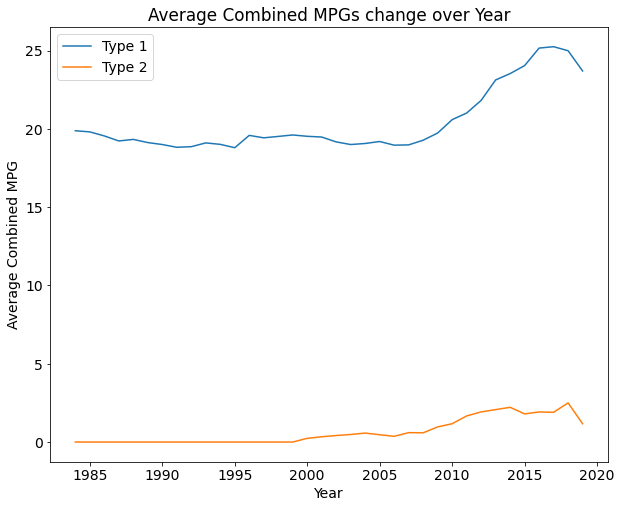

In [542]:
time_eff_comb = vehicle[['comb08','combA08','year']].groupby('year').mean()
time_eff_comb.plot()
plt.legend(labels=['Type 1','Type 2'])
plt.xlabel('Year')
plt.ylabel('Average Combined MPG')
plt.title('Average Combined MPGs change over Year')
plt.show()

In the graph above, we could see both fuel efficiencies (Average Combined MPG) for type 1 and type 2 don't change a lot until the year 2007. After the year 2007, the fuel efficiencies for both two types changed dramatically. However, after the year 2017, the trend of MPG increasing stock. And the MPG went down slightly in the year 2019 because of some reasons,e.g. technology development and the balance between capacities of batteries and the speed of cars.

However, one thing the graph might mislead is the trend of the yellow line (type 2). It remains a low level since most cars in the market are still single fuel. Therefore the type 2 values of these cars are zeros and it lowers the average very much. However, we may only look at the fuel efficiency of dual-fuel cars with alternative fuel (we don't care about the zero values) 

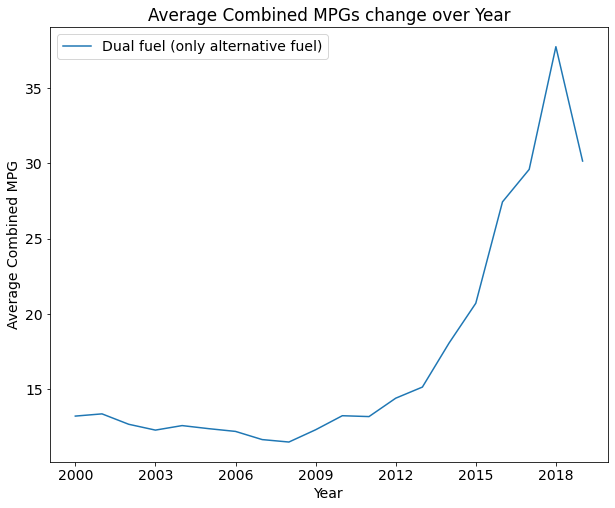

In [556]:
time_eff_comb = vehicle[['combA08','year']].replace(0,np.nan).groupby('year').mean()
time_eff_comb.plot()
plt.legend(labels=['Dual fuel (only alternative fuel)'])
plt.xticks(np.arange(2000, 2020, 3))
plt.xlabel('Year')
plt.ylabel('Average Combined MPG')
plt.title('Average Combined MPGs change over Year')
plt.show()

As the plot above shows that the fuel efficiency of dual-fuel cars with alternative fuel does change and the trend is pretty much the same as the fuel efficiency of the main fuel type of cars (type 1).

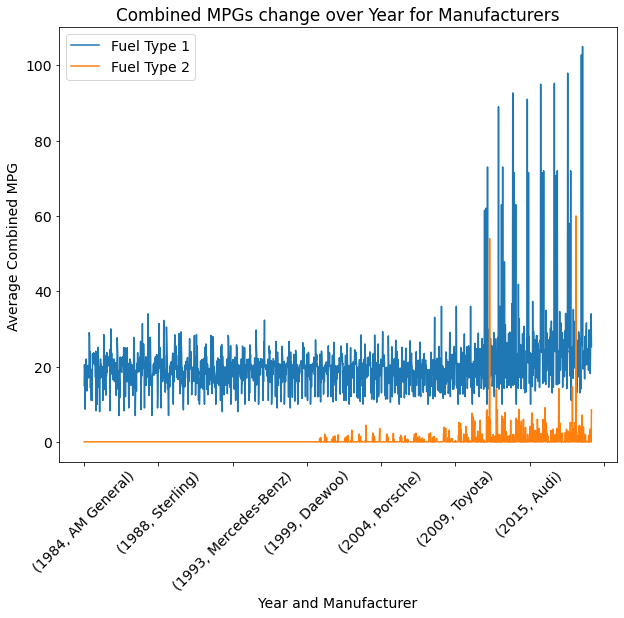

In [557]:
from matplotlib.pyplot import figure
year_make = vehicle[['comb08','combA08','year','make']].groupby(['year','make']).mean()
year_make.plot()
plt.xticks(rotation=45)
plt.legend(labels=['Fuel Type 1','Fuel Type 2'])
plt.xlabel('Year and Manufacturer')
plt.ylabel('Average Combined MPG ')
plt.title('Combined MPGs change over Year for Manufacturers')
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

What if we consider the fuel efficiency changes over time with car manufacturers. The ugly plot above provides an overall sense. The fuel efficiencies increased dramatically in the year 2012.

In [609]:
# Let's focus on the Fastest growing year, 2011 and 2012
common_yr_mk = vehicle[['comb08','combA08','year','make']]
yr_mk_2012 = common_yr_mk[(common_yr_mk['year'] == 2012)].groupby(['year','make']).mean()
yr_mk_2011 = common_yr_mk[(common_yr_mk['year'] == 2011)].groupby(['year','make']).mean()

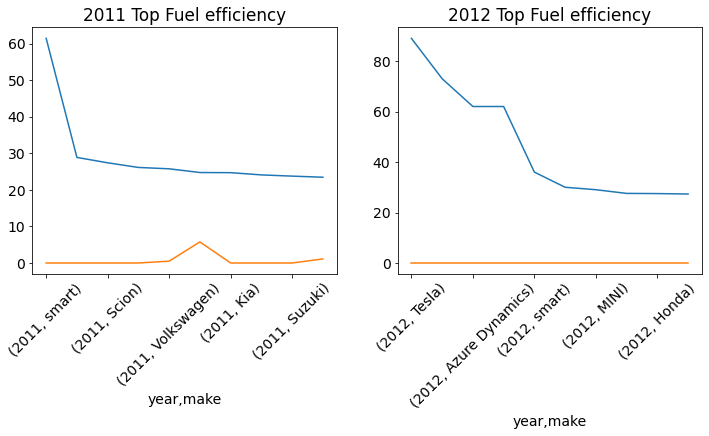

In [611]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
top_2011_time = yr_mk_2011.sort_values(by='comb08',ascending=False)[:10]
top_2011_time['comb08'].plot()
top_2011_time['combA08'].plot()
plt.title("2011 Top Fuel efficiency")
plt.xticks(rotation=45)

plt.subplot(2,2,2)
top_2012_time = yr_mk_2012.sort_values(by='comb08',ascending=False)[:10]
top_2012_time['comb08'].plot()
top_2012_time['combA08'].plot()
plt.title("2012 Top Fuel efficiency")
plt.xticks(rotation=45)
plt.show()

The interesting things are 


1) Tesla accelerates the speed of evolution of fuel efficiency since the year 2012.


2) The 2011 Smart is highly fuel-efficient but the same model in 2012 is not. It decreases from around 60 to 30 MPG. I believe this is because of the bias of the data since the combined MPG of Smart 2011 and 2012 are pretty much the same.



### Additional Explorations (some EDA and feature selection):

In [244]:
from sklearn.inspection import permutation_importance
ftrs_select = permutation_importance(grid_rfr, X_test, y_test, n_repeats=10,random_state=42,scoring='neg_root_mean_squared_error')

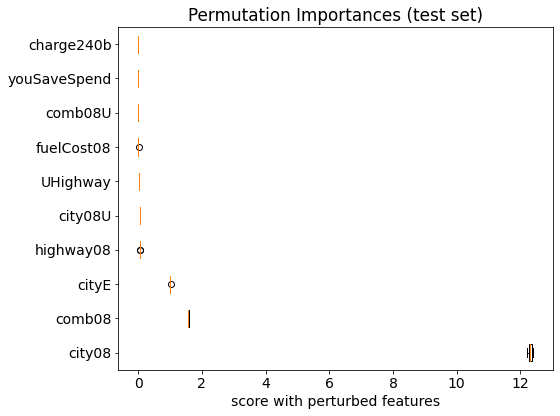

In [250]:
ftr_names = X_test.columns
sorted_index = np.argsort(np.mean(ftrs_select.importances,axis=1))[::-1][:10]
plt.rcParams.update({'font.size':14})
plt.figure(figsize=(8,6))
plt.boxplot(ftrs_select.importances[sorted_index].T,labels=ftr_names[sorted_index], vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed features')
plt.tight_layout()
plt.show()

The graph above shows the importance of the features. The higher score the feature gets, the more important it is to our random forest model prediction.



Here, I found the reason why I have a very low RMSE. It is because city08 (city MPG) is highly correlated with our target variable, UCity (unadjusted city MPG). It makes sense that the city MPG is somehow calculated by unadjusted city MPG. However, many important features are based on city08, e.g. comb08 and city08U. We would have a very bad model prediction if we drop the 'city08'.



Later, to reduce the number of features, we may consider only using these top 10 features to build the model first. Then, building models with 10 features would save a lot of time if the models perform well.

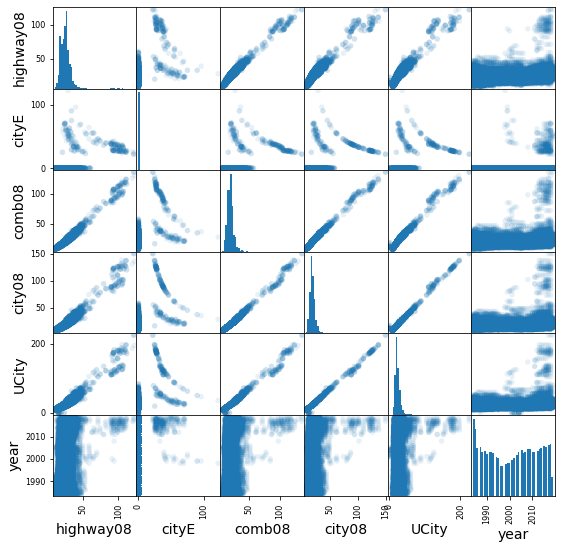

In [349]:
corr_data = vehicle[['highway08','cityE','comb08','city08','UCity','year','make','fuelType']]
pd.plotting.scatter_matrix(corr_data, figsize=(9, 9), marker='o',hist_kwds={'bins': 50}, 
                           s=30, alpha=.1)
plt.show()

If we only look at the column of UCity, we could see that the top features which I selected previously are either positively or negatively correlated with UCity obviously. Therefore, one interesting finding is that I never notice one important feature, cityE (city electricity consumption in kw-hrs/100 miles).

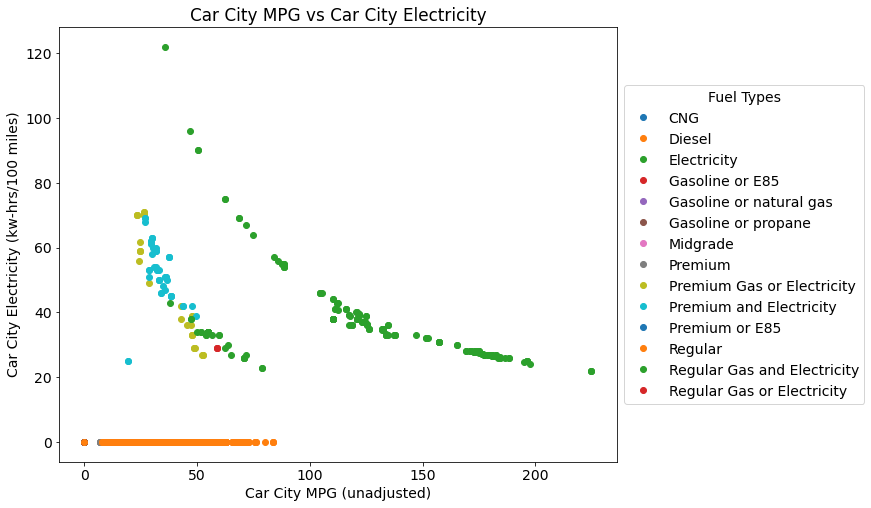

In [612]:
groups = corr_data.groupby('fuelType')
for name, group in groups:
    plt.plot(group['UCity'], group['cityE'], marker="o", linestyle="",label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title='Fuel Types')
plt.xlabel('Car City MPG (unadjusted)')
plt.ylabel('Car City Electricity (kw-hrs/100 miles)')
plt.title('Car City MPG vs Car City Electricity')
plt.show()

The CityE may not make sense to us since the complex unit, kw-hrs/100 miles, and it's the relationship with unadjusted City MPG. Therefore, I transformed the kw-hrs/100 miles to mile/kw-hr (mile/kw-hr = the inverse of kw-hrs/100 miles * 100) Therefore, their relationship is negatively correlated. The higher values of mile/kw-hr mean the more miles the car could be driven in one kilowatt-hour (The energy unit) and the cars are more fuel-efficient.

<ipython-input-613-2b5fab58d34c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data['A_hundred'] = 100
<ipython-input-613-2b5fab58d34c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data['mile_kwh'] = corr_data['A_hundred'] / corr_data['cityE']


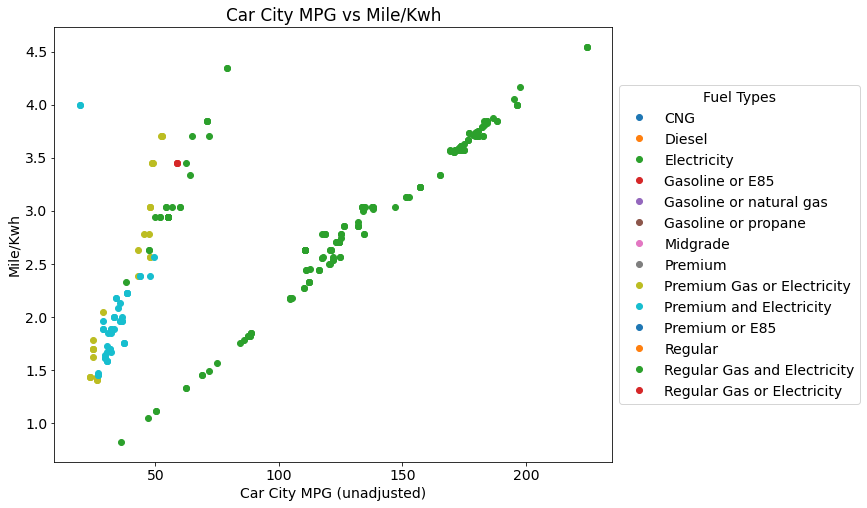

In [613]:
corr_data['A_hundred'] = 100
corr_data['mile_kwh'] = corr_data['A_hundred'] / corr_data['cityE']
for name, group in groups:
    plt.plot(group['UCity'], group['mile_kwh'], marker="o", linestyle="",label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title='Fuel Types')
plt.xlabel('Car City MPG (unadjusted)')
plt.ylabel('Mile/Kwh')
plt.title('Car City MPG vs Mile/Kwh')
plt.show()

The graph above tells us, besides the diesel cars (in general, not fuel economy), most of the single fuel cars (electricity or gas) are more fuel-efficient than the dual fuel cars (e.g. hybrid).

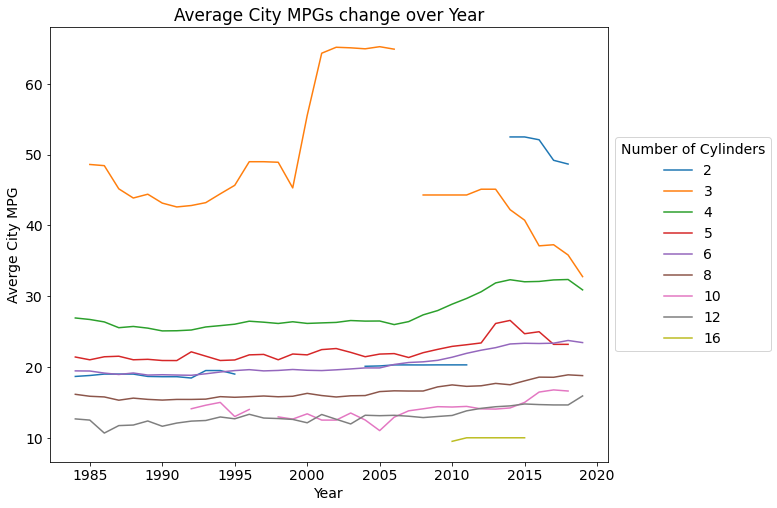

In [561]:
eng_year = vehicle[['cylinders','year','UCity']]
eng_year.groupby(['year','cylinders']).mean().unstack().plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           labels=['2','3','4','5','6','8','10','12','16'],title='Number of Cylinders')
plt.ylabel('Averge City MPG')
plt.xlabel('Year')
plt.title('Average City MPGs change over Year')
plt.show()

The unconnected parts of the lines are the missing values. Generally, the more cylinders the car has, the less fuel-efficient it is. It's very interesting that 3-cylinder cars are extremely more fuel-efficient than 4-cylinder cars. But it begins decreasing since the year 2007. However, the fuel efficiencies of cars with 4 or more cylinders are improving since 2007.

### Thank you so much for your time and consideration!!! Please let me know if you have any further questions and hope to hear from you!